<a href="https://colab.research.google.com/github/fpinell/mlsa/blob/main/AA20252026/exercises/exercise_1_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Software Analysis (MLSA)

#### Fabio Pinelli
<a href="mailto:fabio.pinelli@imtlucca.it">fabio.pinelli@imtlucca.it</a><br/>
IMT School for Advanced Studies Lucca<br/>
2025/2026<br/>
October, 9 2025

## Exercise 1

**Dataset**: KC1 (NASA PROMISE) — static code metrics (Halstead, McCabe/Cyclomatic, LOC...).

**Metrics**:
- *Halstead* (operators/operands, volume, difficulty, effort, estimated bugs) —
[https://en.wikipedia.org/wiki/Halstead_complexity_measures](https://en.wikipedia.org/wiki/Halstead_complexity_measures)

- *Cyclomatic complexity (McCabe)* — [https://en.wikipedia.org/wiki/Cyclomatic_complexity
](https://en.wikipedia.org/wiki/Cyclomatic_complexity
)


**Goal**: binary classification of defective vs non-defective modules.
  
+ **Size / comments**

    - **loc**: "Lines of Code (LOC): total number of lines in the module.",
    - **loccodeandcomment**: "Lines of code including comment lines.",
    - **locode**: "Effective lines of code (no comments/blank).",
    - **locomment**: "Number of comment lines.",
    - **loblank**: "Number of blank lines.",
    - **branchcount**: "Number of branches in the control flow (approx. number of decisions).",

+ **McCabe / Cyclomatic**
    - **v(g)**": "Cyclomatic complexity v(G): number of linearly independent paths in the CFG (McCabe).",
    - **ev(g)**": "Essential complexity ev(G): measures degree of structuredness.",
    - **iv(g)**": "Design complexity iv(G): complexity related to design/call structure.",
    - **cyclomatic_complexity**": "Cyclomatic complexity: number of independent paths.",

+ **Halstead**
    - **uniq_op**: "Halstead: distinct operators (η₁).",
    - **uniq_opnd**: "Halstead: distinct operands (η₂).",
    - **total_op**: "Halstead: total operators (N₁).",
    - **total_opnd**: "Halstead: total operands (N₂).",
    - **n**: "Halstead length N = N₁ + N₂.",
    - **v**: "Halstead volume V = N × log₂(η₁ + η₂).",
    - **l**: "Halstead level L (inverse of difficulty).",
    - **d**: "Halstead difficulty D = (η₁/2) × (N₂/η₂).",
    - **i**: "Halstead intelligence content I = L × V (interpretations vary).",
    - **e**: "Halstead effort E = D × V.",
    - **b**: "Halstead estimated bugs B ≈ V/3000 (or (E^(2/3))/3000).",
    - **t**: "Halstead time to program T = E/18 (seconds)."





In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.base import BaseEstimator, ClassifierMixin
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/fpinell/mlsa/refs/heads/main/AA20252026/data/kc1_modified.csv')

In [3]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nTarget Variable Distribution:")
print(df['defects'].value_counts())
print(f"Defect Rate: {df['defects'].mean():.3f}")


Dataset Shape: (2109, 22)

First few rows:
   ev(g)  iv(g)      n       v     l      d      i         e     b        t  \
0    1.4    1.4    1.3    1.30  1.30   1.30   1.30      1.30  1.30     1.30   
1    1.0    1.0    1.0    1.00  1.00   1.00   1.00      1.00  1.00     1.00   
2    1.0   11.0  171.0  927.89  0.04  23.04  40.27  21378.61  0.31  1187.70   
3    6.0    8.0  141.0  769.78  0.07  14.86  51.81  11436.73  0.26   635.37   
4    1.0    3.0   58.0  254.75  0.11   9.35  27.25   2381.95  0.08   132.33   

   ...  loblank  loccodeandcomment  uniq_op  uniq_opnd  total_op  total_opnd  \
0  ...        2                  2      1.2        1.2       1.2         1.2   
1  ...        1                  1      1.0        1.0       1.0         1.0   
2  ...        6                  0     18.0       25.0     107.0        64.0   
3  ...        5                  0     16.0       28.0      89.0        52.0   
4  ...        2                  0     11.0       10.0      41.0        17.0   

 

In [4]:
# Check for missing values
print("Missing Values per Column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remove target variable from numerical columns
numerical_cols = [col for col in numerical_cols if col != 'defects']

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")
print(f"Total features: {len(categorical_cols) + len(numerical_cols)}")


Missing Values per Column:
ev(g)    112
iv(g)    112
dtype: int64

Categorical columns: ['loc_qbin', 'v(g)_bin']
Numerical columns: ['ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'locode', 'locomment', 'loblank', 'loccodeandcomment', 'uniq_op', 'uniq_opnd', 'total_op', 'total_opnd', 'branchcount']
Total features: 21


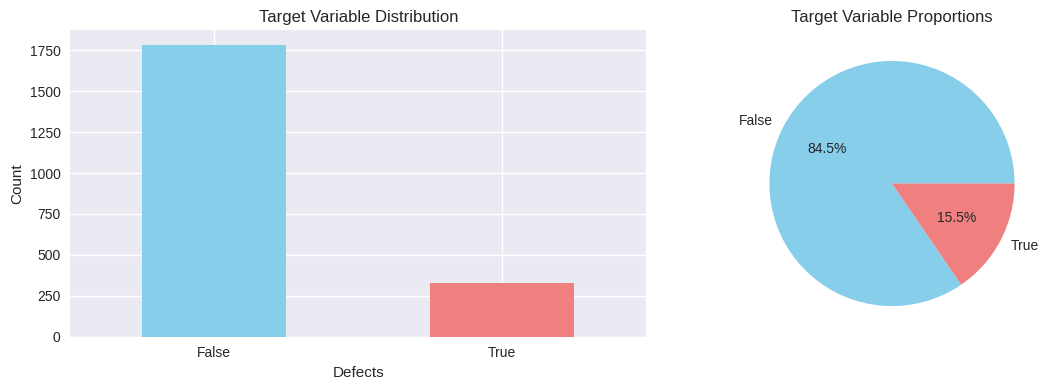

In [5]:
# Target variable visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['defects'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Target Variable Distribution')
plt.xlabel('Defects')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['defects'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%',
                                               colors=['skyblue', 'lightcoral'])
plt.title('Target Variable Proportions')
plt.ylabel('')

plt.tight_layout()
plt.show()


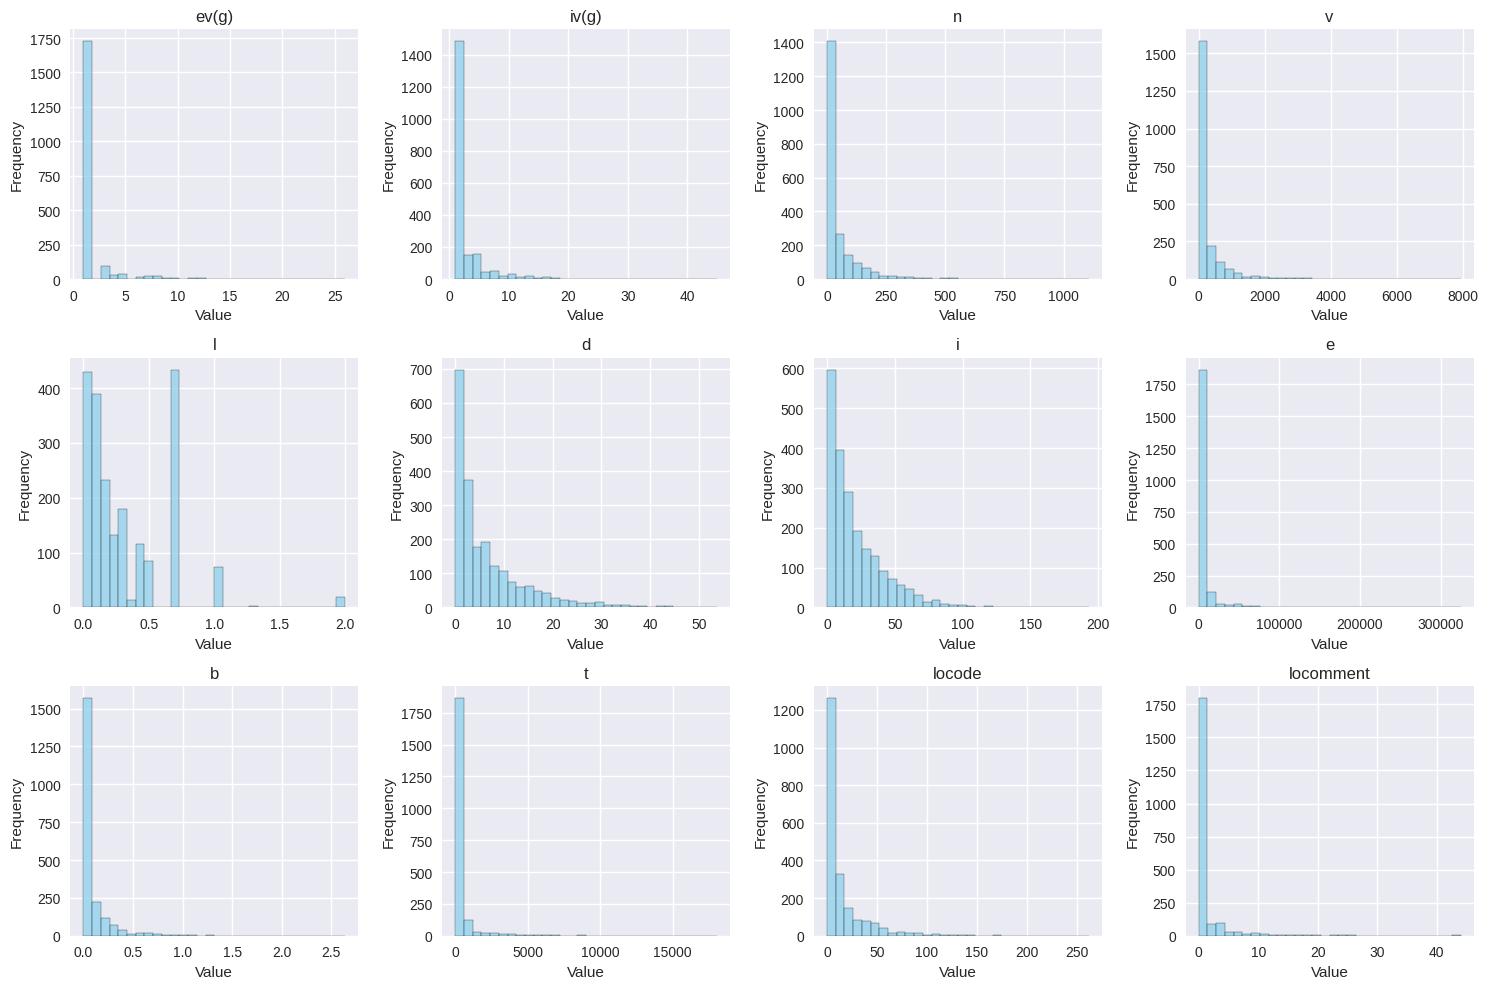

In [6]:
# Numerical features distribution
plt.figure(figsize=(15, 10))

# Select a subset of numerical features for visualization
num_features_subset = numerical_cols[:12]  # First 12 numerical features

for i, col in enumerate(num_features_subset):
    plt.subplot(3, 4, i+1)
    df[col].hist(bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'{col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


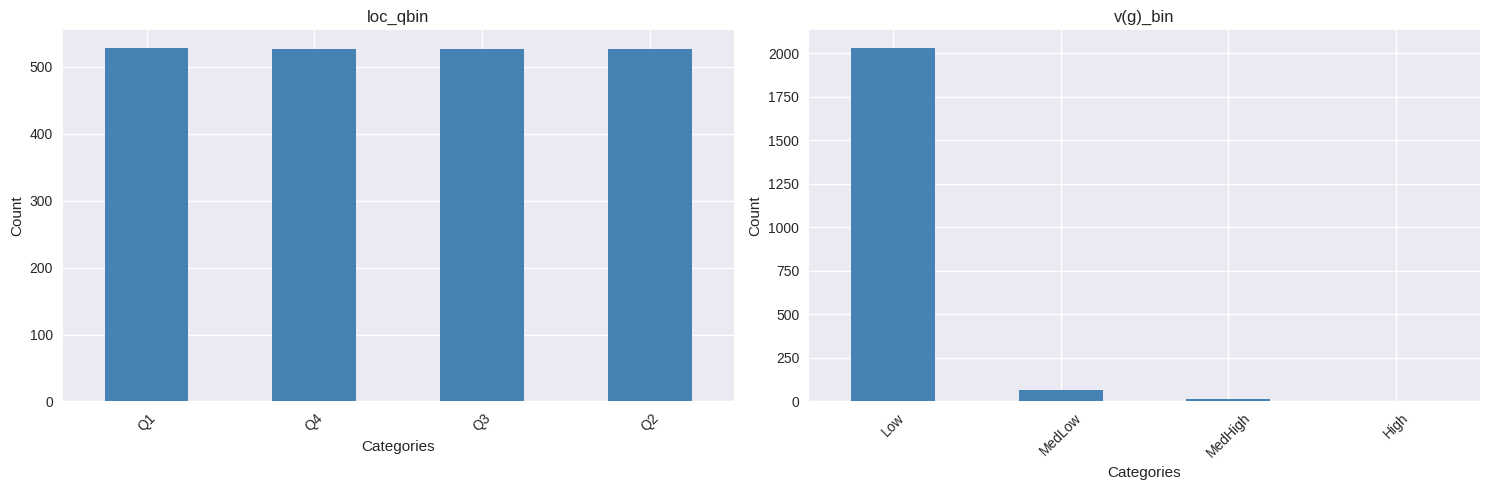


loc_qbin unique values: ['Q1' 'Q4' 'Q3' 'Q2']
loc_qbin value counts:
loc_qbin
Q1    528
Q4    527
Q3    527
Q2    527
Name: count, dtype: int64

v(g)_bin unique values: ['Low' 'MedLow' 'MedHigh' 'High']
v(g)_bin value counts:
v(g)_bin
Low        2029
MedLow       65
MedHigh      14
High          1
Name: count, dtype: int64


In [7]:
# Categorical features analysis
if categorical_cols:
    plt.figure(figsize=(15, 5))

    for i, col in enumerate(categorical_cols):
        plt.subplot(1, len(categorical_cols), i+1)
        df[col].value_counts().plot(kind='bar', color='steelblue')
        plt.title(f'{col}')
        plt.xlabel('Categories')
        plt.ylabel('Count')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Show unique values for categorical columns
    for col in categorical_cols:
        print(f"\n{col} unique values: {df[col].unique()}")
        print(f"{col} value counts:\n{df[col].value_counts()}")


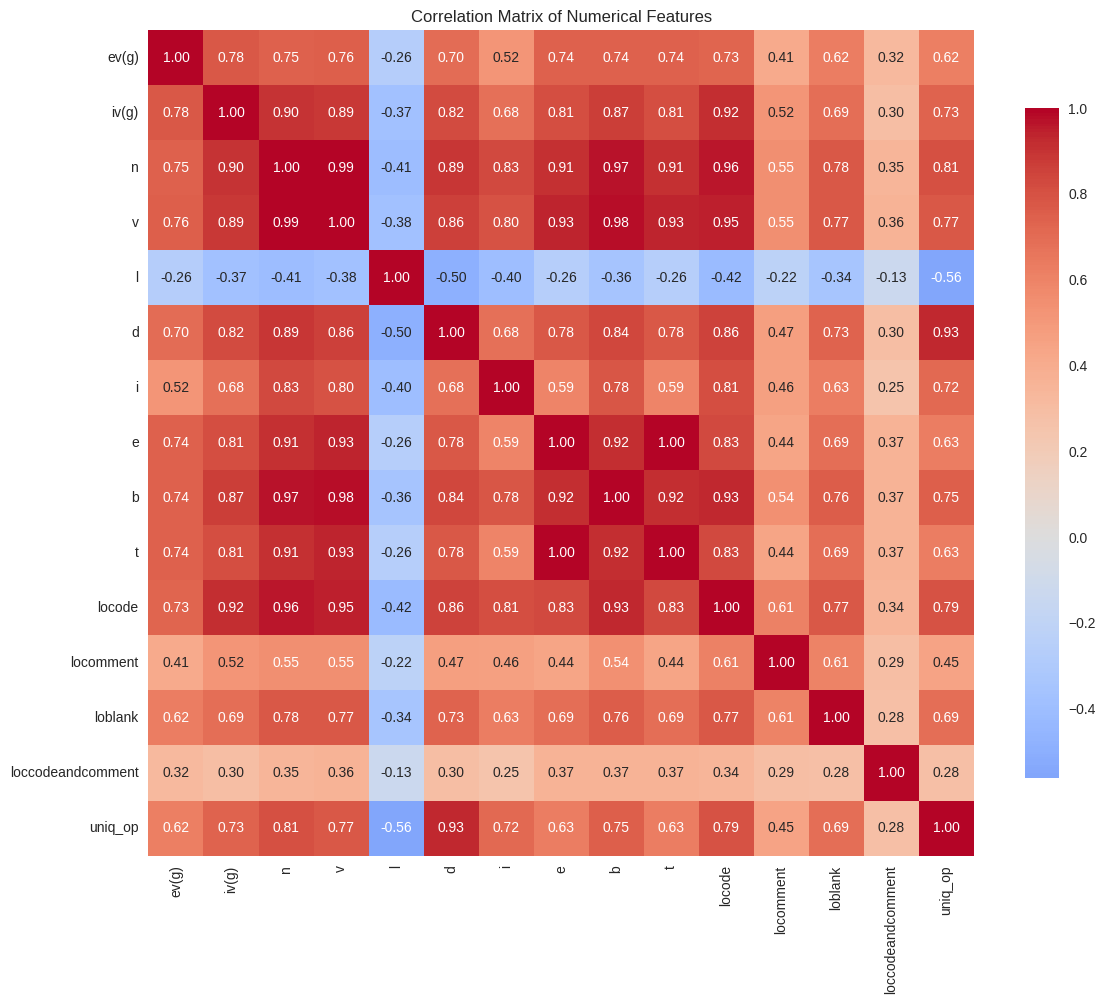

In [8]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 10))

# Select a subset of numerical features for correlation matrix
correlation_features = numerical_cols[:15]  # First 15 features for readability
correlation_matrix = df[correlation_features].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

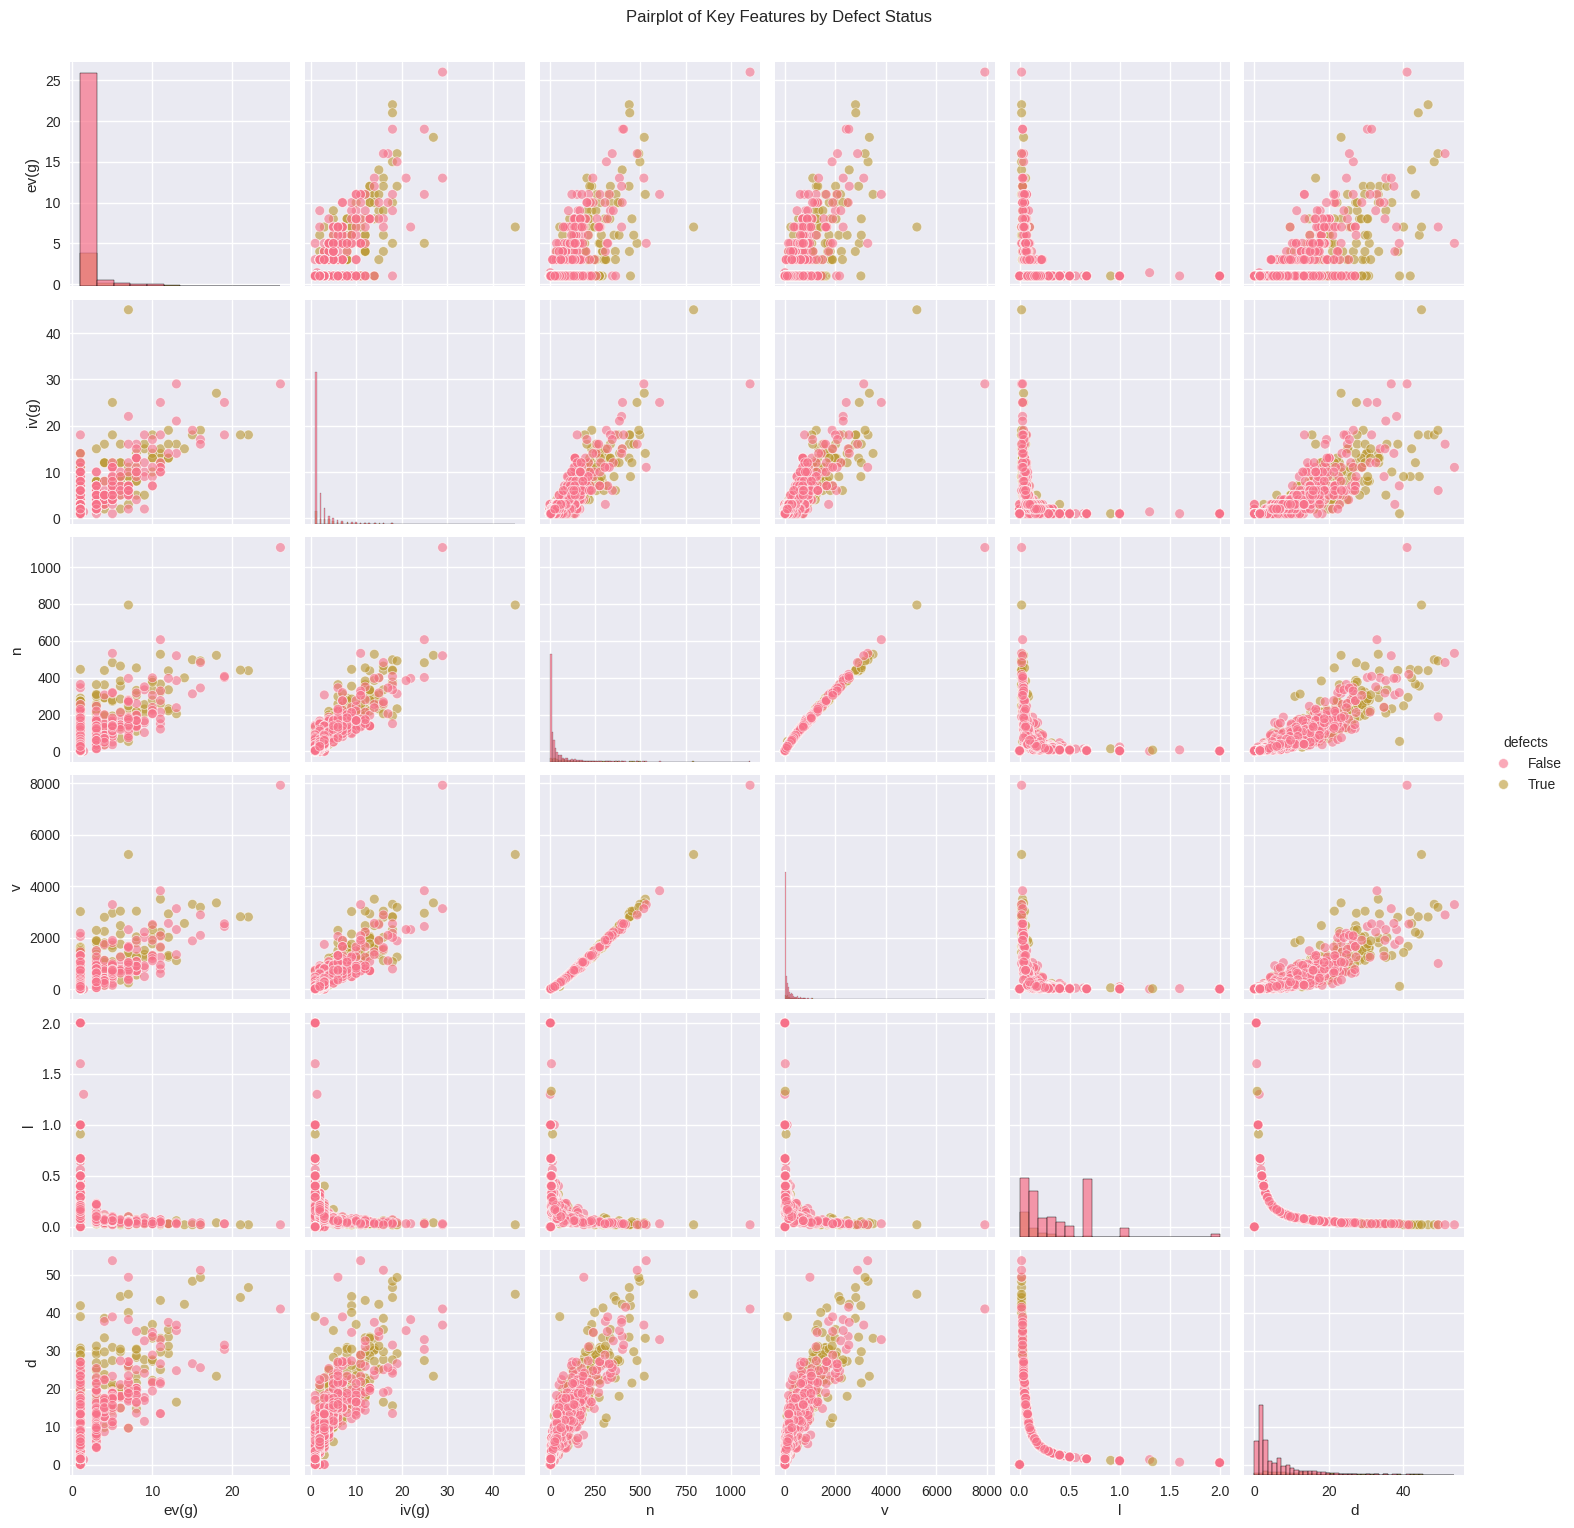

In [9]:
# Seaborn pairplot for a subset of features
# Select a few key numerical features for pairplot
pairplot_features = numerical_cols[:6] + ['defects']  # First 6 numerical features + target

plt.figure(figsize=(12, 8))
sns.pairplot(df[pairplot_features], hue='defects', diag_kind='hist',
             plot_kws={'alpha': 0.6}, diag_kws={'alpha': 0.7})
plt.suptitle('Pairplot of Key Features by Defect Status', y=1.02)
plt.show()


## 2.1. Data Cleaning: Duplicate Analysis and Resolution

This section handles duplicate rows in the dataset, particularly focusing on cases where the same feature combinations have different target labels (inconsistent duplicates).

**Key Issues Addressed:**
- **Duplicate rows**: Same feature values appearing multiple times
- **Inconsistent labels**: Same features but different target values (e.g., one row says "defect=True", another says "defect=False")
- **Data quality**: Ensuring clean, consistent data for machine learning

**Resolution Strategy:**
- **Non-duplicates**: Keep as-is (preserves all unique rows)
- **Inconsistent duplicates**: Use "defect priority" - prefer True labels over False
- **Consistent duplicates**: Keep first occurrence

This approach ensures that:
1. No unique rows are lost
2. Inconsistent duplicates are resolved logically
3. The dataset maintains its original characteristics while being cleaner


In [10]:
# Data Cleaning: Handle Duplicates with Inconsistent Labels
print("="*60)
print("DATA CLEANING")
print("="*60)

# Store original dataset size
original_size = len(df)
print(f"Original dataset size: {original_size}")

# Check for inconsistent duplicates (same features, different target labels)
feature_cols = [col for col in df.columns if col != 'defects']
duplicate_mask = df.duplicated(subset=feature_cols, keep=False)
inconsistent_groups = df[duplicate_mask].groupby(feature_cols)['defects'].nunique()
inconsistent_duplicates = (inconsistent_groups > 1).sum()
print(f"Groups with inconsistent target labels: {inconsistent_duplicates}")

if inconsistent_duplicates > 0:
    print(f"Handling {inconsistent_duplicates} inconsistent duplicate groups...")

    # Keep non-duplicates as-is
    non_duplicates = df[~duplicate_mask]

    # Handle only the actual duplicates
    def resolve_inconsistent_group(group):
        if group['defects'].nunique() > 1:
            return group[group['defects'] == True].iloc[0] if (group['defects'] == True).any() else group.iloc[0]
        else:
            return group.iloc[0]

    # Process only duplicate groups
    duplicate_groups = df[duplicate_mask].groupby(feature_cols, group_keys=False).apply(resolve_inconsistent_group).reset_index(drop=True)

    # Combine non-duplicates with resolved duplicates
    df_cleaned = pd.concat([non_duplicates, duplicate_groups], ignore_index=True)

    print(f"Resolved inconsistent duplicates using 'defect priority' strategy")
else:
    # Simple duplicate removal if no inconsistencies
    df_cleaned = df.drop_duplicates(subset=feature_cols, keep='first')
    print(f"No inconsistent duplicates found - using simple duplicate removal")

duplicates_removed = original_size - len(df_cleaned)
print(f"Duplicates removed: {duplicates_removed}")
print(f"Cleaned dataset size: {len(df_cleaned)}")
print(f"Reduction: {(duplicates_removed/original_size*100):.2f}%")

# Check target variable distribution after cleaning
print(f"\nTarget variable distribution after cleaning:")
print(df_cleaned['defects'].value_counts())
print(f"Defect rate after cleaning: {df_cleaned['defects'].mean():.3f}")

# Compare with original
original_defect_rate = df['defects'].mean()
cleaned_defect_rate = df_cleaned['defects'].mean()
print(f"\nDefect rate change: {original_defect_rate:.3f} → {cleaned_defect_rate:.3f}")
print(f"Change: {(cleaned_defect_rate - original_defect_rate):.3f}")

# Update df to use cleaned version
df = df_cleaned.copy()
print(f"\n✅ Dataset cleaned! Using {len(df)} samples for analysis.")


DATA CLEANING
Original dataset size: 2109
Groups with inconsistent target labels: 23
Handling 23 inconsistent duplicate groups...
Resolved inconsistent duplicates using 'defect priority' strategy
Duplicates removed: 941
Cleaned dataset size: 1168
Reduction: 44.62%

Target variable distribution after cleaning:
defects
False    856
True     312
Name: count, dtype: int64
Defect rate after cleaning: 0.267

Defect rate change: 0.155 → 0.267
Change: 0.113

✅ Dataset cleaned! Using 1168 samples for analysis.


In [11]:
df.isnull().sum()

,0
ev(g),74
iv(g),74
n,0
v,0
l,0
d,0
i,0
e,0
b,0
t,0


In [14]:
# Prepare features and target
X = df.drop('defects', axis=1)
y = df['defects']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set defect rate: {y_train.mean():.3f}")
print(f"Test set defect rate: {y_test.mean():.3f}")

# Verify stratification worked
print(f"\nOriginal dataset defect rate: {y.mean():.3f}")
print(f"Training set defect rate: {y_train.mean():.3f}")
print(f"Test set defect rate: {y_test.mean():.3f}")


Training set size: 934 samples
Test set size: 234 samples
Training set defect rate: 0.267
Test set defect rate: 0.269

Original dataset defect rate: 0.267
Training set defect rate: 0.267
Test set defect rate: 0.269


In [15]:
# Create preprocessing pipeline with default settings
# Default: OrdinalEncoder, SimpleImputer(median), MinMaxScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_cols)
    ],
    remainder='passthrough'
)

print("Default preprocessing pipeline created:")
print("Numerical features: SimpleImputer(median) + MinMaxScaler")
print("Categorical features: SimpleImputer(constant) + OrdinalEncoder")
print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")


Default preprocessing pipeline created:
Numerical features: SimpleImputer(median) + MinMaxScaler
Categorical features: SimpleImputer(constant) + OrdinalEncoder
Numerical columns: ['ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'locode', 'locomment', 'loblank', 'loccodeandcomment', 'uniq_op', 'uniq_opnd', 'total_op', 'total_opnd', 'branchcount']
Categorical columns: ['loc_qbin', 'v(g)_bin']


In [16]:
# Create full pipeline with Logistic Regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Default Pipeline Results:")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Accuracy: {pipeline.score(X_test, y_test):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Default Pipeline Results:
ROC-AUC Score: 0.6834
Accuracy: 0.7692

Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.99      0.86       171
        True       0.91      0.16      0.27        63

    accuracy                           0.77       234
   macro avg       0.84      0.58      0.57       234
weighted avg       0.80      0.77      0.70       234



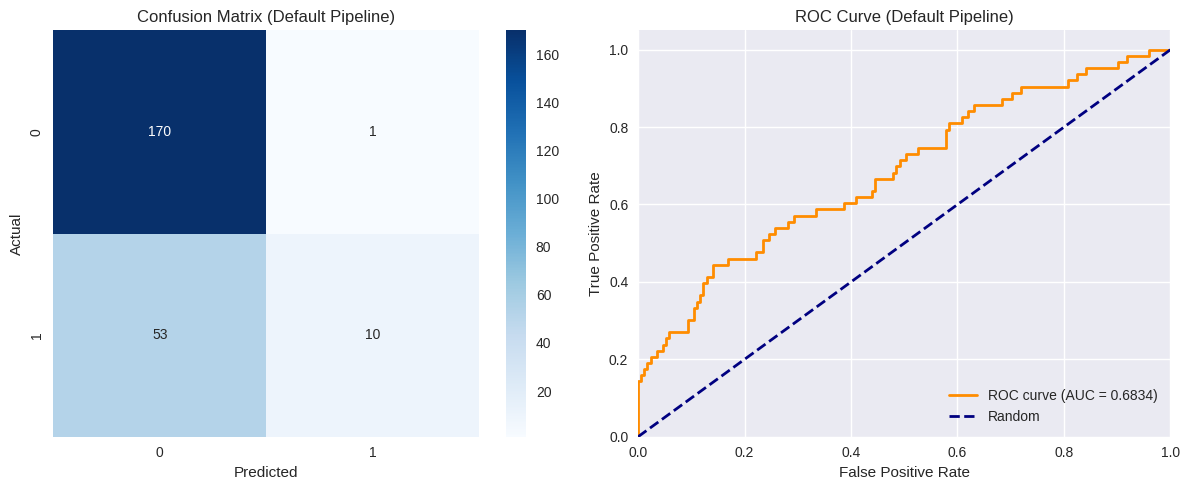

In [17]:
# Confusion Matrix and ROC Curve for default pipeline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix (Default Pipeline)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve (Default Pipeline)')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()


## 6. GridSearchCV with Multiple Preprocessing and Classifier Options

Now we'll implement a comprehensive GridSearchCV that tests different combinations of:
- **Categorical encoders**: OrdinalEncoder vs OneHotEncoder
- **Imputers**: Median vs Mean
- **Scalers**: MinMaxScaler vs StandardScaler vs No scaling
- **Classifiers**: LogisticRegression vs RandomForest vs XGBoost


In [18]:
# Custom Random Classifier Implementation
class RandomClassifier(BaseEstimator, ClassifierMixin):
    """
    A custom random classifier that inherits from BaseEstimator and ClassifierMixin.
    This classifier makes random predictions based on the training data distribution.
    """

    def __init__(self, strategy='stratified', random_state=None):
        """
        Initialize the Random Classifier.

        Parameters:
        -----------
        strategy : str, default='stratified'
            Strategy for random predictions:
            - 'uniform': Random predictions with equal probability for each class
            - 'stratified': Random predictions based on class distribution in training data
            - 'most_frequent': Always predict the most frequent class
        random_state : int, default=None
            Random state for reproducibility
        """
        self.strategy = strategy
        self.random_state = random_state
        self.classes_ = None
        self.class_prior_ = None
        self.n_classes_ = None

    def fit(self, X, y):
        """
        Fit the random classifier to the training data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data (ignored for random classifier)
        y : array-like of shape (n_samples,)
            Target values

        Returns:
        --------
        self : object
            Returns self
        """
        # Set random state
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Store class information
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)

        # Calculate class probabilities based on strategy
        if self.strategy == 'uniform':
            self.class_prior_ = np.ones(self.n_classes_) / self.n_classes_
        elif self.strategy == 'stratified':
            # Use actual class distribution
            class_counts = np.bincount(y)
            self.class_prior_ = class_counts / len(y)
        elif self.strategy == 'most_frequent':
            # Always predict the most frequent class
            class_counts = np.bincount(y)
            most_frequent_idx = np.argmax(class_counts)
            self.class_prior_ = np.zeros(self.n_classes_)
            self.class_prior_[most_frequent_idx] = 1.0
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")

        return self

    def predict(self, X):
        """
        Make random predictions for the test data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Test data (ignored for random classifier)

        Returns:
        --------
        y_pred : array-like of shape (n_samples,)
            Random predictions
        """
        if self.classes_ is None:
            raise ValueError("Classifier must be fitted before making predictions")

        # Set random state for reproducibility
        if self.random_state is not None:
            np.random.seed(self.random_state)

        n_samples = X.shape[0]

        if self.strategy == 'most_frequent':
            # Always predict the most frequent class
            most_frequent_class = self.classes_[np.argmax(self.class_prior_)]
            return np.full(n_samples, most_frequent_class)
        else:
            # Random predictions based on class probabilities
            return np.random.choice(self.classes_, size=n_samples, p=self.class_prior_)

    def predict_proba(self, X):
        """
        Return random class probabilities for the test data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Test data (ignored for random classifier)

        Returns:
        --------
        y_proba : array-like of shape (n_samples, n_classes)
            Random class probabilities
        """
        if self.classes_ is None:
            raise ValueError("Classifier must be fitted before making predictions")

        n_samples = X.shape[0]

        if self.strategy == 'most_frequent':
            # Return probabilities for most frequent class
            proba = np.zeros((n_samples, self.n_classes_))
            most_frequent_idx = np.argmax(self.class_prior_)
            proba[:, most_frequent_idx] = 1.0
            return proba
        else:
            # Return random probabilities based on class distribution
            proba = np.random.dirichlet(self.class_prior_ * 10, size=n_samples)  # *10 for more realistic probabilities
            return proba

    def score(self, X, y):
        """
        Return the mean accuracy on the given test data and labels.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Test data
        y : array-like of shape (n_samples,)
            True labels

        Returns:
        --------
        score : float
            Mean accuracy
        """
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

print("Custom RandomClassifier class created successfully!")


Custom RandomClassifier class created successfully!


In [19]:
# Create a flexible pipeline for GridSearchCV
def create_pipeline():
    return Pipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imputer', SimpleImputer()),
                    ('scaler', 'passthrough')  # Will be set in grid search
                ]), numerical_cols),
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                    ('encoder', 'passthrough')  # Will be set in grid search
                ]), categorical_cols)
            ],
            remainder='passthrough'
        )),
        ('classifier', 'passthrough')  # Will be set in grid search
    ])

# Define parameter grid
param_grid = {
    # Numerical preprocessing
    'preprocessor__num__imputer__strategy': ['median', 'mean'],
    'preprocessor__num__scaler': [
        MinMaxScaler(),
        StandardScaler(),
        'passthrough'  # No scaling
    ],

    # Categorical preprocessing
    'preprocessor__cat__encoder': [
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ],

    # Classifiers
    'classifier': [
        LogisticRegression(random_state=42, max_iter=1000),
        RandomForestClassifier(random_state=42, n_estimators=100),
        RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10),
        xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        xgb.XGBClassifier(random_state=42, n_estimators=200, max_depth=6, eval_metric='logloss'),
        RandomClassifier(strategy='stratified', random_state=42),  # Custom stratified classifier
        RandomClassifier(strategy='uniform', random_state=42),  # Custom uniform classifier
        RandomClassifier(strategy='most_frequent', random_state=42)  # Custom most_frequent classifier
    ]
}

print("Parameter grid created with:")
print(f"- {len(param_grid['preprocessor__num__imputer__strategy'])} imputer strategies")
print(f"- {len(param_grid['preprocessor__num__scaler'])} scaler options")
print(f"- {len(param_grid['preprocessor__cat__encoder'])} encoder options")
print(f"- {len(param_grid['classifier'])} classifier options")
print(f"Total combinations: {len(param_grid['preprocessor__num__imputer__strategy']) * len(param_grid['preprocessor__num__scaler']) * len(param_grid['preprocessor__cat__encoder']) * len(param_grid['classifier'])}")


Parameter grid created with:
- 2 imputer strategies
- 3 scaler options
- 2 encoder options
- 8 classifier options
Total combinations: 96


In [20]:
# Perform GridSearchCV
print("Starting GridSearchCV...")
print("This may take several minutes depending on your system...")

grid_search = GridSearchCV(
    estimator=create_pipeline(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,  # Use all available cores
    verbose=3
)

# Fit the grid search
grid_search.fit(X_train, y_train)

print("GridSearchCV completed!")
print(f"Best ROC-AUC Score: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")


Starting GridSearchCV...
This may take several minutes depending on your system...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
GridSearchCV completed!
Best ROC-AUC Score: 0.6852
Best Parameters: {'classifier': RandomForestClassifier(random_state=42), 'preprocessor__cat__encoder': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': 'passthrough'}


### 6.1 GridSearchCV with Multiple Preprocessing and Classifier Options

Now we'll implement a comprehensive GridSearchCV that tests different combinations of:
- **Categorical encoders**: OrdinalEncoder (with proper categories) vs OneHotEncoder
- **Imputers**: Median vs Mean
- **Scalers**: MinMaxScaler vs StandardScaler vs No scaling
- **Classifiers**: LogisticRegression vs RandomForest vs XGBoost vs RandomClassifier

**Key Improvement**: Using proper ordinal categories for categorical features:
- `loc_qbin`: Q1, Q2, Q3, Q4 (ordered from lowest to highest quartile)
- `v(g)_bin`: Low, MedLow, MedHigh, High (ordered from lowest to highest complexity)


In [ ]:
# Create a flexible pipeline for GridSearchCV
def create_pipeline():
    return Pipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imputer', SimpleImputer()),
                    ('scaler', 'passthrough')  # Will be set in grid search
                ]), numerical_cols),
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                    ('encoder', 'passthrough')  # Will be set in grid search
                ]), categorical_cols)
            ],
            remainder='passthrough'
        )),
        ('classifier', 'passthrough')  # Will be set in grid search
    ])

# Define parameter grid with proper ordinal categories
param_grid = {
    # Numerical preprocessing
    'preprocessor__num__imputer__strategy': ['median', 'mean'],
    'preprocessor__num__scaler': [
        MinMaxScaler(),
        StandardScaler(),
        'passthrough'  # No scaling
    ],

    # Categorical preprocessing with proper ordinal categories
    'preprocessor__cat__encoder': [
        # OrdinalEncoder with proper categories for both features
        OrdinalEncoder(
            categories=[['Q1', 'Q2', 'Q3', 'Q4'], ['Low', 'MedLow', 'MedHigh', 'High']],
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ),
        # OneHotEncoder for comparison
        OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ],

    # Classifiers
    'classifier': [
        LogisticRegression(random_state=42, max_iter=1000),
        RandomForestClassifier(random_state=42, n_estimators=100),
        RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10),
        xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        xgb.XGBClassifier(random_state=42, n_estimators=200, max_depth=6, eval_metric='logloss'),
        # Multiple RandomClassifier strategies for comprehensive baseline comparison
        RandomClassifier(strategy='uniform', random_state=42),
        RandomClassifier(strategy='stratified', random_state=42),
        RandomClassifier(strategy='most_frequent', random_state=42)
    ]
}

print("Parameter grid created with:")
print(f"- {len(param_grid['preprocessor__num__imputer__strategy'])} imputer strategies")
print(f"- {len(param_grid['preprocessor__num__scaler'])} scaler options")
print(f"- {len(param_grid['preprocessor__cat__encoder'])} encoder options")
print(f"- {len(param_grid['classifier'])} classifier options")

total_combinations = (len(param_grid['preprocessor__num__imputer__strategy']) *
                    len(param_grid['preprocessor__num__scaler']) *
                    len(param_grid['preprocessor__cat__encoder']) *
                    len(param_grid['classifier']))
print(f"Total combinations: {total_combinations}")

print("\nKey improvements:")
print("✅ OrdinalEncoder with proper categories: Q1<Q2<Q3<Q4, Low<MedLow<MedHigh<High")
print("✅ Multiple RandomClassifier strategies for baseline comparison")
print("✅ Comprehensive preprocessing and classifier options")


Parameter grid created with:
- 2 imputer strategies
- 3 scaler options
- 2 encoder options
- 8 classifier options
Total combinations: 96

Key improvements:
✅ OrdinalEncoder with proper categories: Q1<Q2<Q3<Q4, Low<MedLow<MedHigh<High
✅ Multiple RandomClassifier strategies for baseline comparison
✅ Comprehensive preprocessing and classifier options


In [ ]:
# Execute GridSearchCV
print("Starting GridSearchCV...")
print("This may take several minutes depending on the number of combinations.")

# Create GridSearchCV
grid_search = GridSearchCV(
    create_pipeline(),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

print("\nGridSearchCV completed!")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
accuracy_best = best_model.score(X_test, y_test)

print(f"\nBest Model Performance on Test Set:")
print(f"ROC-AUC Score: {roc_auc_best:.4f}")
print(f"Accuracy: {accuracy_best:.4f}")

# Show top 5 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print(f"\nTop 5 parameter combinations:")
for i, (idx, row) in enumerate(top_5.iterrows(), 1):
    print(f"{i}. Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   Parameters: {row['params']}")
    print()


Starting GridSearchCV...
This may take several minutes depending on the number of combinations.
Fitting 5 folds for each of 96 candidates, totalling 480 fits

GridSearchCV completed!
Best cross-validation score: 0.6852
Best parameters: {'classifier': RandomForestClassifier(random_state=42), 'preprocessor__cat__encoder': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': 'passthrough'}

Best Model Performance on Test Set:
ROC-AUC Score: 0.7234
Accuracy: 0.7821

Top 5 parameter combinations:
1. Score: 0.6852 (±0.0180)
   Parameters: {'classifier': RandomForestClassifier(random_state=42), 'preprocessor__cat__encoder': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': 'passthrough'}

2. Score: 0.6850 (±0.0187)
   Parameters: {'classifier': RandomForestClassifier(random_state=42), 'preprocessor__cat__encoder': OneHotEn

## 7. Model Evaluation and Comparison


In [21]:
# Evaluate the best model on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics for best model
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
accuracy_best = best_model.score(X_test, y_test)

print("Best Model Results (Test Set):")
print(f"ROC-AUC Score: {roc_auc_best:.4f}")
print(f"Accuracy: {accuracy_best:.4f}")

print("\nBest Model Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Classification report for best model
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))


Best Model Results (Test Set):
ROC-AUC Score: 0.7234
Accuracy: 0.7821

Best Model Parameters:
classifier: RandomForestClassifier(random_state=42)
preprocessor__cat__encoder: OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor__num__imputer__strategy: mean
preprocessor__num__scaler: passthrough

Classification Report (Best Model):
              precision    recall  f1-score   support

       False       0.80      0.93      0.86       171
        True       0.67      0.38      0.48        63

    accuracy                           0.78       234
   macro avg       0.73      0.66      0.67       234
weighted avg       0.77      0.78      0.76       234



In [22]:
# Create and evaluate custom random classifier baseline
print("Creating Custom Random Classifier Baseline...")

# Random classifier with different strategies
random_strategies = ['uniform', 'most_frequent', 'stratified']

random_results = {}

for strategy in random_strategies:
    print(f"\nTesting Custom Random Classifier with '{strategy}' strategy:")

    # Create custom random classifier
    random_clf = RandomClassifier(strategy=strategy, random_state=42)

    # Fit and predict
    random_clf.fit(X_train, y_train)
    y_pred_random = random_clf.predict(X_test)
    y_pred_proba_random = random_clf.predict_proba(X_test)[:, 1]

    # Calculate metrics
    roc_auc_random = roc_auc_score(y_test, y_pred_proba_random)
    accuracy_random = random_clf.score(X_test, y_test)

    # Store results
    random_results[strategy] = {
        'roc_auc': roc_auc_random,
        'accuracy': accuracy_random,
        'predictions': y_pred_random,
        'probabilities': y_pred_proba_random,
        'classifier': random_clf
    }

    print(f"  ROC-AUC: {roc_auc_random:.4f}")
    print(f"  Accuracy: {accuracy_random:.4f}")
    print(f"  Class distribution learned: {random_clf.class_prior_}")

# Use stratified random classifier as our main baseline (most fair comparison)
baseline_random = random_results['stratified']
print(f"\nSelected 'stratified' custom random classifier as baseline:")
print(f"Baseline ROC-AUC: {baseline_random['roc_auc']:.4f}")
print(f"Baseline Accuracy: {baseline_random['accuracy']:.4f}")
print(f"Learned class probabilities: {baseline_random['classifier'].class_prior_}")


Creating Custom Random Classifier Baseline...

Testing Custom Random Classifier with 'uniform' strategy:
  ROC-AUC: 0.4724
  Accuracy: 0.4786
  Class distribution learned: [0.5 0.5]

Testing Custom Random Classifier with 'most_frequent' strategy:
  ROC-AUC: 0.5000
  Accuracy: 0.7308
  Class distribution learned: [1. 0.]

Testing Custom Random Classifier with 'stratified' strategy:
  ROC-AUC: 0.5669
  Accuracy: 0.6410
  Class distribution learned: [0.73340471 0.26659529]

Selected 'stratified' custom random classifier as baseline:
Baseline ROC-AUC: 0.5669
Baseline Accuracy: 0.6410
Learned class probabilities: [0.73340471 0.26659529]


Comprehensive Model Comparison:
Random Baseline ROC-AUC:   0.5669
Default Pipeline ROC-AUC:  0.6834
Best Model ROC-AUC:        0.7234
Improvement over Random:   0.1565
Improvement over Default:  0.0401

Random Baseline Accuracy:  0.6410
Default Pipeline Accuracy: 0.7692
Best Model Accuracy:       0.7821
Improvement over Random:   0.1410
Improvement over Default:  0.0128

Summary Table:
           Model  ROC-AUC  Accuracy
 Random Baseline   0.5669    0.6410
Default Pipeline   0.6834    0.7692
      Best Model   0.7234    0.7821


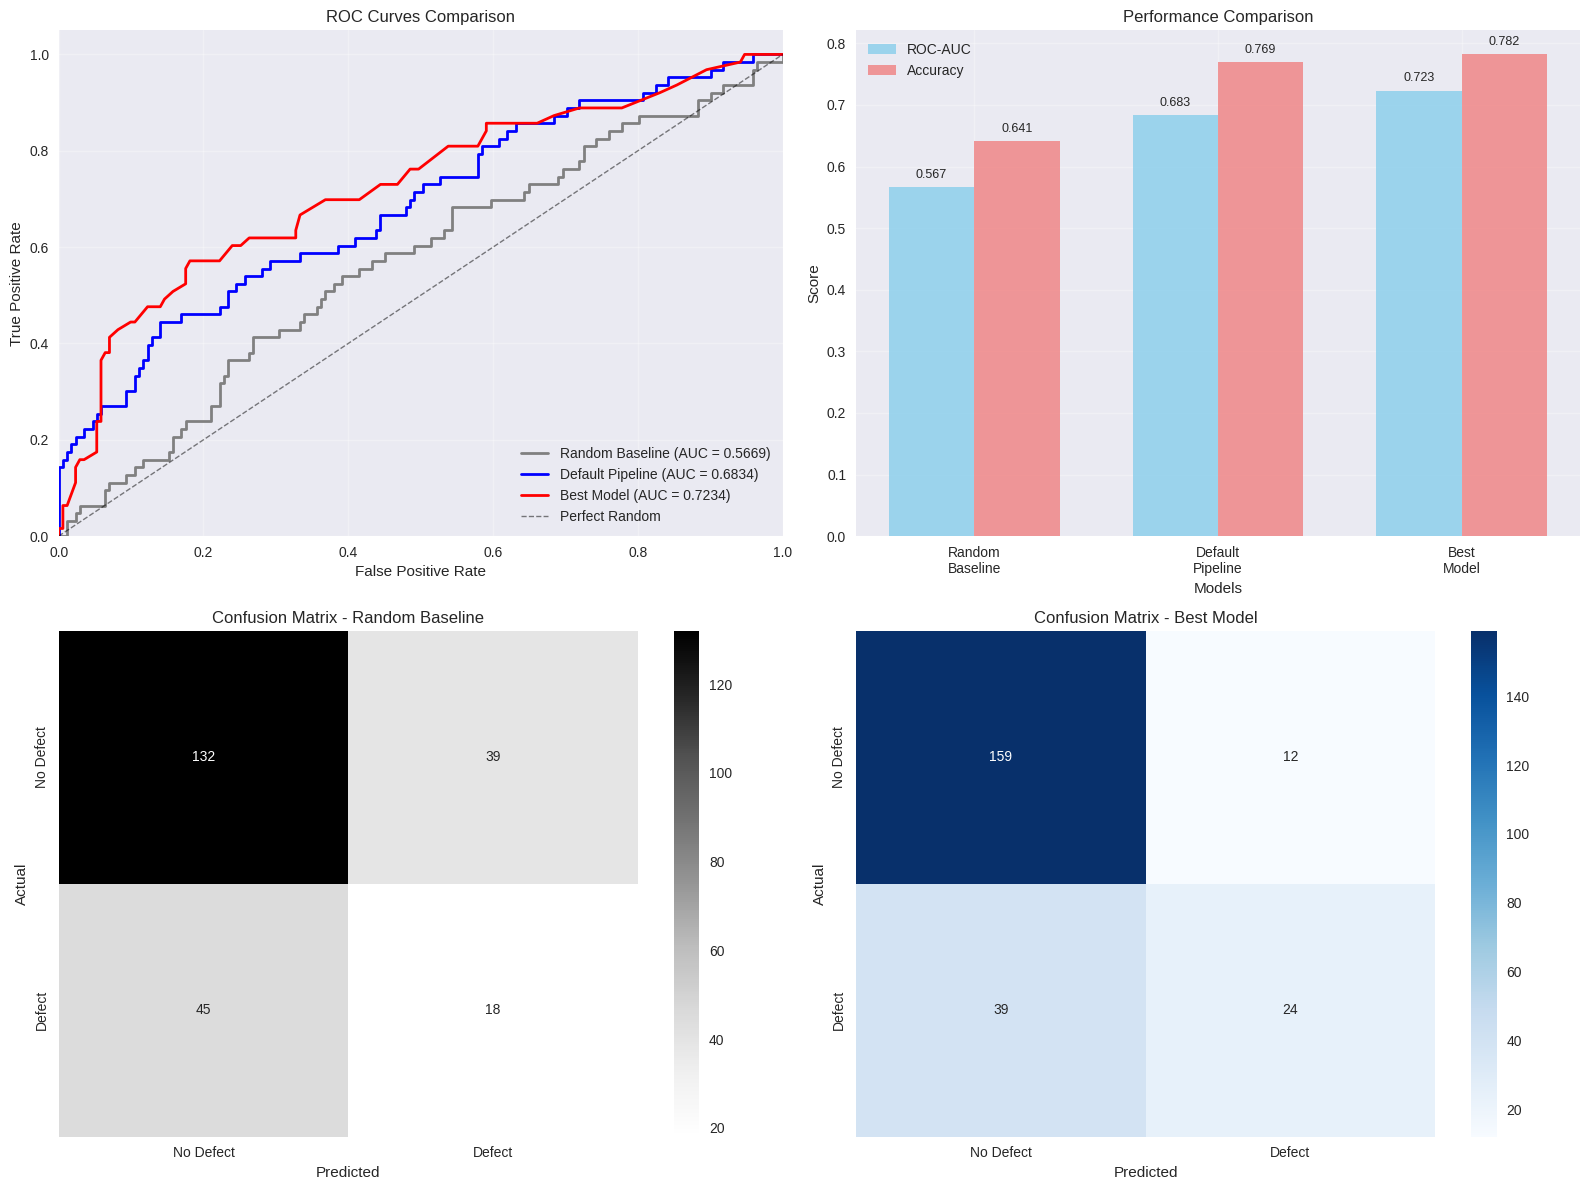

In [23]:
# Compare all models including random baseline
print("Comprehensive Model Comparison:")
print("=" * 60)
print(f"Random Baseline ROC-AUC:   {baseline_random['roc_auc']:.4f}")
print(f"Default Pipeline ROC-AUC:  {roc_auc:.4f}")
print(f"Best Model ROC-AUC:        {roc_auc_best:.4f}")
print(f"Improvement over Random:   {roc_auc_best - baseline_random['roc_auc']:.4f}")
print(f"Improvement over Default:  {roc_auc_best - roc_auc:.4f}")

print(f"\nRandom Baseline Accuracy:  {baseline_random['accuracy']:.4f}")
print(f"Default Pipeline Accuracy: {pipeline.score(X_test, y_test):.4f}")
print(f"Best Model Accuracy:       {accuracy_best:.4f}")
print(f"Improvement over Random:   {accuracy_best - baseline_random['accuracy']:.4f}")
print(f"Improvement over Default:  {accuracy_best - pipeline.score(X_test, y_test):.4f}")

# Create comparison summary
comparison_data = {
    'Model': ['Random Baseline', 'Default Pipeline', 'Best Model'],
    'ROC-AUC': [baseline_random['roc_auc'], roc_auc, roc_auc_best],
    'Accuracy': [baseline_random['accuracy'], pipeline.score(X_test, y_test), accuracy_best]
}

comparison_df = pd.DataFrame(comparison_data)
print(f"\nSummary Table:")
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Visualize comparison including random baseline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# ROC Curves Comparison
fpr_random, tpr_random, _ = roc_curve(y_test, baseline_random['probabilities'])
fpr_default, tpr_default, _ = roc_curve(y_test, y_pred_proba)
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)

ax1.plot(fpr_random, tpr_random, color='gray', lw=2,
         label=f'Random Baseline (AUC = {baseline_random["roc_auc"]:.4f})')
ax1.plot(fpr_default, tpr_default, color='blue', lw=2,
         label=f'Default Pipeline (AUC = {roc_auc:.4f})')
ax1.plot(fpr_best, tpr_best, color='red', lw=2,
         label=f'Best Model (AUC = {roc_auc_best:.4f})')
ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', alpha=0.5, label='Perfect Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves Comparison')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Performance Comparison Bar Chart
models = ['Random\nBaseline', 'Default\nPipeline', 'Best\nModel']
roc_aucs = [baseline_random['roc_auc'], roc_auc, roc_auc_best]
accuracies = [baseline_random['accuracy'], pipeline.score(X_test, y_test), accuracy_best]

x = np.arange(len(models))
width = 0.35

bars1 = ax2.bar(x - width/2, roc_aucs, width, label='ROC-AUC', alpha=0.8, color='skyblue')
bars2 = ax2.bar(x + width/2, accuracies, width, label='Accuracy', alpha=0.8, color='lightcoral')

ax2.set_xlabel('Models')
ax2.set_ylabel('Score')
ax2.set_title('Performance Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Confusion Matrix - Random Baseline
cm_random = confusion_matrix(y_test, baseline_random['predictions'])
sns.heatmap(cm_random, annot=True, fmt='d', cmap='Greys', ax=ax3,
            xticklabels=['No Defect', 'Defect'], yticklabels=['No Defect', 'Defect'])
ax3.set_title('Confusion Matrix - Random Baseline')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# Confusion Matrix - Best Model
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['No Defect', 'Defect'], yticklabels=['No Defect', 'Defect'])
ax4.set_title('Confusion Matrix - Best Model')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.show()


Top 10 Models by ROC-AUC Score:

1. ROC-AUC: 0.6852 (+/- 0.0360)
   Classifier: RandomForestClassifier
   Imputer: mean
   Scaler: passthrough
   Encoder: OneHotEncoder

2. ROC-AUC: 0.6850 (+/- 0.0374)
   Classifier: RandomForestClassifier
   Imputer: mean
   Scaler: StandardScaler
   Encoder: OneHotEncoder

3. ROC-AUC: 0.6845 (+/- 0.0358)
   Classifier: RandomForestClassifier
   Imputer: mean
   Scaler: MinMaxScaler
   Encoder: OneHotEncoder

4. ROC-AUC: 0.6831 (+/- 0.0466)
   Classifier: RandomForestClassifier
   Imputer: median
   Scaler: passthrough
   Encoder: OrdinalEncoder

5. ROC-AUC: 0.6831 (+/- 0.0502)
   Classifier: RandomForestClassifier
   Imputer: mean
   Scaler: MinMaxScaler
   Encoder: OrdinalEncoder

6. ROC-AUC: 0.6830 (+/- 0.0492)
   Classifier: RandomForestClassifier
   Imputer: mean
   Scaler: StandardScaler
   Encoder: OrdinalEncoder

7. ROC-AUC: 0.6830 (+/- 0.0461)
   Classifier: RandomForestClassifier
   Imputer: median
   Scaler: MinMaxScaler
   Encoder: Ordinal

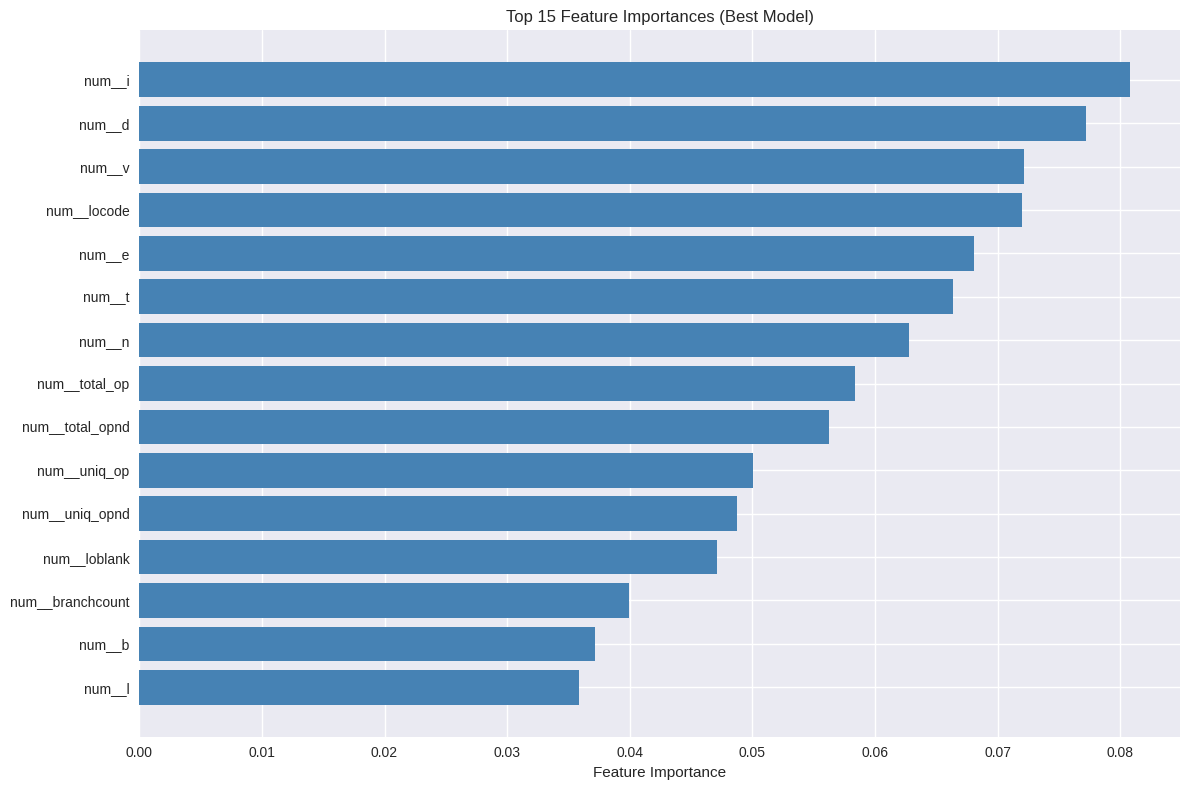

In [24]:
# Analyze top performing models
results_df = pd.DataFrame(grid_search.cv_results_)

# Get top 10 models by mean test score
top_models = results_df.nlargest(10, 'mean_test_score')[
    ['mean_test_score', 'std_test_score', 'params']
].copy()

print("Top 10 Models by ROC-AUC Score:")
print("=" * 60)

for i, (idx, row) in enumerate(top_models.iterrows(), 1):
    print(f"\n{i}. ROC-AUC: {row['mean_test_score']:.4f} (+/- {row['std_test_score']*2:.4f})")

    # Extract key parameters for readability
    params = row['params']
    classifier_name = str(params['classifier']).split('(')[0]
    imputer_strategy = params['preprocessor__num__imputer__strategy']
    scaler_name = str(params['preprocessor__num__scaler']).split('(')[0]
    encoder_name = str(params['preprocessor__cat__encoder']).split('(')[0]

    print(f"   Classifier: {classifier_name}")
    print(f"   Imputer: {imputer_strategy}")
    print(f"   Scaler: {scaler_name}")
    print(f"   Encoder: {encoder_name}")

# Feature importance analysis (if best model supports it)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # print("\n" + "="*60)
    # print("Feature Importance Analysis (Best Model)")
    # print("="*60)

    # Get feature names after preprocessing
    X_transformed = best_model.named_steps['preprocessor'].transform(X_train)
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

    # Get feature importances
    importances = best_model.named_steps['classifier'].feature_importances_

    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Display top 15 most important features
    # print("\nTop 15 Most Important Features:")
    # print(feature_importance_df.head(15).to_string(index=False))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'],color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances (Best Model)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [ ]:
# Strategy 1: Threshold Tuning to Reduce False Positives
print("="*60)
print("THRESHOLD TUNING FOR FALSE POSITIVE REDUCTION")
print("="*60)

from sklearn.metrics import precision_recall_curve, roc_curve

# Get predictions from the best model (already preprocessed)
y_pred_proba_best = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best)

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_best)

# Find optimal threshold that minimizes false positives while maintaining good precision
# We'll look for thresholds that give us high precision (low false positive rate)
optimal_thresholds = []

# Test different thresholds
test_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
threshold_results = []

for threshold in test_thresholds:
    y_pred_thresh = (y_pred_proba_best >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)

    tn, fp, fn, tp = cm.ravel()

    precision_thresh = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_thresh = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_thresh = 2 * (precision_thresh * recall_thresh) / (precision_thresh + recall_thresh) if (precision_thresh + recall_thresh) > 0 else 0

    threshold_results.append({
        'threshold': threshold,
        'false_positives': fp,
        'true_positives': tp,
        'false_negatives': fn,
        'precision': precision_thresh,
        'recall': recall_thresh,
        'f1_score': f1_thresh
    })

    print(f"Threshold {threshold:.1f}: FP={fp}, TP={tp}, Precision={precision_thresh:.3f}, Recall={recall_thresh:.3f}")

# Find threshold that minimizes false positives while maintaining reasonable recall
threshold_df = pd.DataFrame(threshold_results)
print(f"\nThreshold Analysis Summary:")
print(threshold_df[['threshold', 'false_positives', 'precision', 'recall', 'f1_score']].round(3))

# Recommend optimal threshold (balance between low FP and reasonable recall)
# Choose threshold that gives us the best precision-recall trade-off
optimal_idx = threshold_df['f1_score'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_fp = threshold_df.loc[optimal_idx, 'false_positives']
optimal_precision = threshold_df.loc[optimal_idx, 'precision']
optimal_recall = threshold_df.loc[optimal_idx, 'recall']

print(f"\n🎯 RECOMMENDED THRESHOLD: {optimal_threshold}")
print(f"   False Positives: {optimal_fp}")
print(f"   Precision: {optimal_precision:.3f}")
print(f"   Recall: {optimal_recall:.3f}")
print(f"   F1-Score: {threshold_df.loc[optimal_idx, 'f1_score']:.3f}")

# Apply optimal threshold
y_pred_optimal = (y_pred_proba_best >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

print(f"\nConfusion Matrix with Optimal Threshold ({optimal_threshold}):")
print(cm_optimal)


THRESHOLD TUNING FOR FALSE POSITIVE REDUCTION
Threshold 0.3: FP=50, TP=39, Precision=0.438, Recall=0.619
Threshold 0.4: FP=30, TP=35, Precision=0.538, Recall=0.556
Threshold 0.5: FP=12, TP=24, Precision=0.667, Recall=0.381
Threshold 0.6: FP=6, TP=10, Precision=0.625, Recall=0.159
Threshold 0.7: FP=1, TP=4, Precision=0.800, Recall=0.063
Threshold 0.8: FP=1, TP=2, Precision=0.667, Recall=0.032
Threshold 0.9: FP=0, TP=1, Precision=1.000, Recall=0.016

Threshold Analysis Summary:
   threshold  false_positives  precision  recall  f1_score
0        0.3               50      0.438   0.619     0.513
1        0.4               30      0.538   0.556     0.547
2        0.5               12      0.667   0.381     0.485
3        0.6                6      0.625   0.159     0.253
4        0.7                1      0.800   0.063     0.118
5        0.8                1      0.667   0.032     0.061
6        0.9                0      1.000   0.016     0.031

🎯 RECOMMENDED THRESHOLD: 0.4
   False Positive